In [2]:
#!pip install -r "requirements.txt"

In [1014]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt

In [1015]:
pd.options.display.max_columns = None

In [1021]:
train = pd.read_csv("./train.csv")
test = pd.read_csv("./test.csv")
pokemon = pd.read_csv("./pokemon.csv", index_col="#")

In [1024]:
train

,First_pokemon,Second_pokemon,Winner
0,516,472,516
1,710,771,710
2,163,779,163
3,420,510,420
4,557,163,163
...,...,...,...
37495,223,319,223
37496,368,344,368
37497,775,664,664
37498,373,633,633


# Analisi

In [1019]:
train.dtypes

First_pokemon     int64
Second_pokemon    int64
Winner            int64
dtype: object

In [1020]:
pokemon.dtypes

Name          object
Type 1        object
Type 2        object
HP             int64
Attack         int64
Defense        int64
Sp. Atk        int64
Sp. Def        int64
Speed          int64
Generation     int64
Legendary       bool
dtype: object

## Valori mancanti / nulli

In [968]:
pokemon.isnull().sum()

Name            1
Type 1          0
Type 2        386
HP              0
Attack          0
Defense         0
Sp. Atk         0
Sp. Def         0
Speed           0
Generation      0
Legendary       0
dtype: int64

In [969]:
train.isnull().sum()

Winner            0
First_pokemon     0
Second_pokemon    0
dtype: int64

In [970]:
print(f"Missing (type 2) { len(pokemon[pokemon['Type 2'].isnull()]) / len(pokemon.index) * 100 }% ")

Missing (type 2) 48.25% 


### Considerazioni
- E' presente un Pokemon con un nome mancante
- 386 Pokemon non hanno un tipo 2 (48,25% del dataset di training)

## Percentuale di vincita
Viene definita la percentuale di vincita per ogni pokemon, allo scopo di poter analizzare come varia in base alle altre features.

In [971]:
winner_count = train.groupby("Winner").count()
win_percentage = winner_count['First_pokemon'] + winner_count['Second_pokemon'] / len(train.index) * 100
pokemon['win_percentage'] = win_percentage

### Analisi Feature "Type 1"
La tipologia determina la probabilità di vincita, pokemon di tipo "flying", "dragon", "dark", nel training set hanno vinto più volte in percentuale.

<AxesSubplot:xlabel='Type 1', ylabel='win_percentage'>

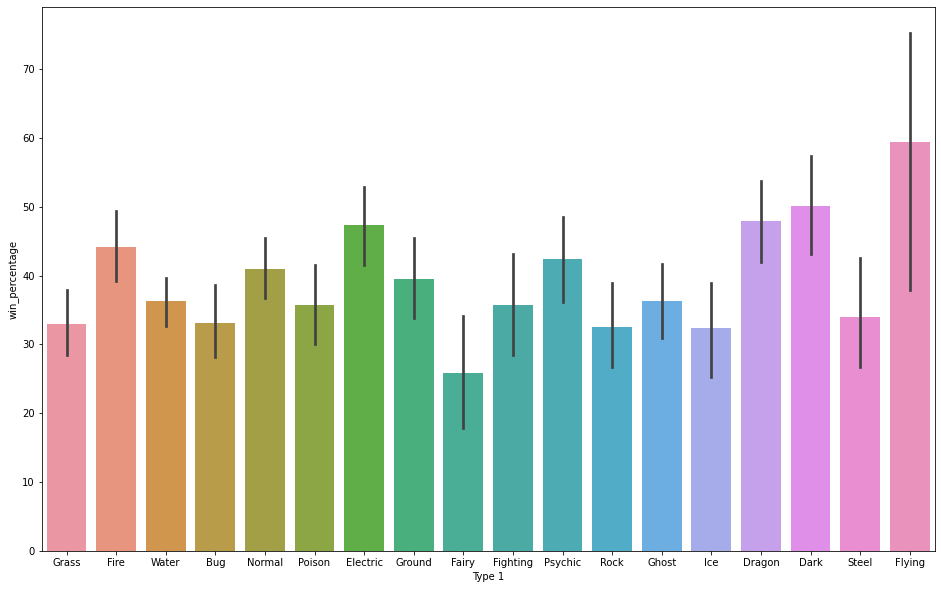

In [972]:
plt.figure(figsize=(16, 10))
sns.barplot(x="Type 1", y="win_percentage", data=pokemon)

### Analisi Feature "Speed"
E' presente un trend positivo, all'aumentare della "speed" aumenta la percentuale di vittoria.

<AxesSubplot:xlabel='Speed', ylabel='win_percentage'>

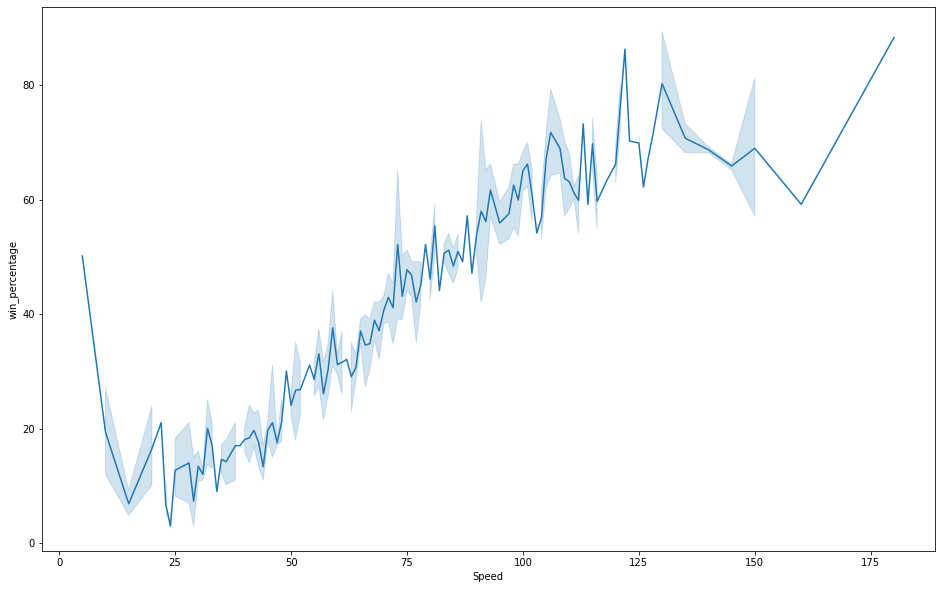

In [973]:
plt.figure(figsize=(16, 10))
sns.lineplot(x="Speed", y="win_percentage", data=pokemon)

## Analisi Feature "Defense"
La feature "Defense" sembra abbastanza randomica, presenta infatti un line chart ricco di picchi

<AxesSubplot:xlabel='Defense', ylabel='win_percentage'>

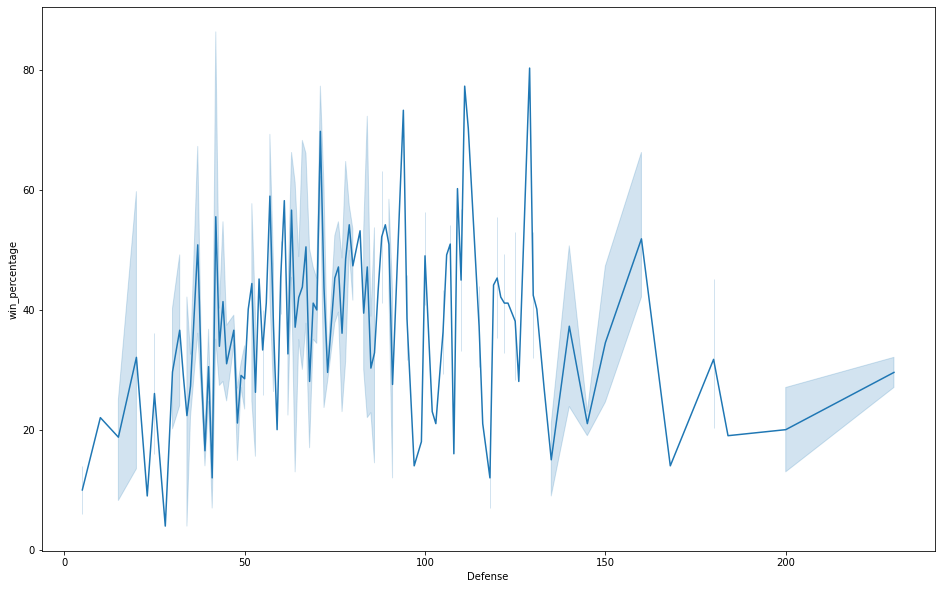

In [974]:
plt.figure(figsize=(16, 10))
sns.lineplot(x="Defense", y="win_percentage", data=pokemon)

## Correlazione
La feature "Generation" ha una correlazione con "Win_percentage" prossima allo zero. Probabilmete può essere droppata.

<AxesSubplot:>

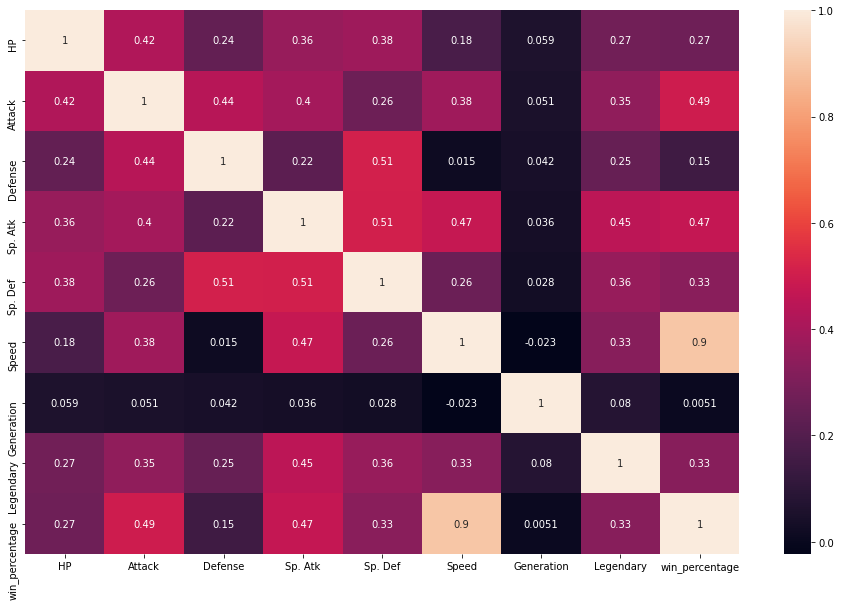

In [975]:
corr = pokemon.corr()
plt.figure(figsize=(16, 10))
sns.heatmap(data=corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=True)

# Preprocessing

In [976]:
pokemon.drop(columns='win_percentage', inplace=True)

In [1025]:
def convertTarget(_df):
    df = _df.copy()
    df['Winner'] = (df['Winner'] == df['First_pokemon']).map(lambda el: 1 if el else 2)
    return df


In [1026]:
train = convertTarget(train)
test = convertTarget(test)

In [1027]:
columns_to_drop = ['Name', 'Type 2', 'Generation', 'Defense']
for col in columns_to_drop:
    try:
        pokemon = pokemon.drop(columns=col)
    except:
        continue

In [1028]:
pokemon.Legendary = pokemon.Legendary.map(lambda el: 1 if el else 0)

In [1029]:
pokemon.head()

,Type 1,HP,Attack,Sp. Atk,Sp. Def,Speed,Legendary
#,,,,,,,
1,Grass,45,49,65,65,45,0
2,Grass,60,62,80,80,60,0
3,Grass,80,82,100,100,80,0
4,Grass,80,100,122,120,80,0
5,Fire,39,52,60,50,65,0


In [1030]:
def mergePokemonsData(df):
    full_data = pd.merge(df, pokemon.add_prefix("First_pokemon_"), how="left", left_on=['First_pokemon'], right_index=True)
    full_data = pd.merge(full_data, pokemon.add_prefix("Second_pokemon_"), how="left", left_on=['Second_pokemon'],  right_index=True)
    full_data.drop(columns=['First_pokemon', 'Second_pokemon'], inplace=True)
    return full_data

In [1031]:
full_train_data = mergePokemonsData(train)
full_test_data = mergePokemonsData(test)
full_train_data

,Winner,First_pokemon_Type 1,First_pokemon_HP,First_pokemon_Attack,First_pokemon_Sp. Atk,First_pokemon_Sp. Def,First_pokemon_Speed,First_pokemon_Legendary,Second_pokemon_Type 1,Second_pokemon_HP,Second_pokemon_Attack,Second_pokemon_Sp. Atk,Second_pokemon_Sp. Def,Second_pokemon_Speed,Second_pokemon_Legendary
0,1,Ground,115,140,55,55,40,0,Normal,75,100,60,66,115,0
1,1,Ground,89,145,105,80,91,1,Fairy,95,65,110,130,60,0
2,1,Psychic,106,110,154,90,130,1,Ghost,43,70,50,60,38,0
3,1,Dragon,80,90,130,110,110,1,Grass,60,62,62,60,40,0
4,2,Grass,75,75,75,95,113,0,Psychic,106,110,154,90,130,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37495,1,Ground,65,75,35,65,85,0,Normal,84,71,71,43,48,0
37496,1,Normal,73,115,60,60,90,0,Bug,65,47,73,75,85,0
37497,2,Dragon,45,50,55,75,40,0,Electric,35,55,45,40,60,0
37498,2,Water,110,78,76,71,60,0,Dark,60,105,120,60,105,0


In [1032]:
encoder = LabelEncoder()
categorical_cols = ['First_pokemon_Type 1', 'Second_pokemon_Type 1']
for col in categorical_cols:
    try:
        full_train_data[col] = encoder.fit_transform(full_train_data[col])
        full_test_data[col] = encoder.fit_transform(full_test_data[col])
    except:
        continue

In [1033]:
full_train_data

,Winner,First_pokemon_Type 1,First_pokemon_HP,First_pokemon_Attack,First_pokemon_Sp. Atk,First_pokemon_Sp. Def,First_pokemon_Speed,First_pokemon_Legendary,Second_pokemon_Type 1,Second_pokemon_HP,Second_pokemon_Attack,Second_pokemon_Sp. Atk,Second_pokemon_Sp. Def,Second_pokemon_Speed,Second_pokemon_Legendary
0,1,10,115,140,55,55,40,0,12,75,100,60,66,115,0
1,1,10,89,145,105,80,91,1,4,95,65,110,130,60,0
2,1,14,106,110,154,90,130,1,8,43,70,50,60,38,0
3,1,2,80,90,130,110,110,1,9,60,62,62,60,40,0
4,2,9,75,75,75,95,113,0,14,106,110,154,90,130,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37495,1,10,65,75,35,65,85,0,12,84,71,71,43,48,0
37496,1,12,73,115,60,60,90,0,0,65,47,73,75,85,0
37497,2,2,45,50,55,75,40,0,3,35,55,45,40,60,0
37498,2,17,110,78,76,71,60,0,1,60,105,120,60,105,0


In [1034]:
#sns.countplot(x=full_data['First_pokemon_Type 1'], hue=full_data['Winner'])

In [1035]:
#sns.countplot(x=full_data['Second_pokemon_Type 1'], hue=full_data['Winner'])

In [1036]:
#sns.countplot(x=full_data['First_pokemon_Legendary'], hue=full_data['Winner'])

In [1037]:
#sns.countplot(x=full_data['Second_pokemon_Legendary'], hue=full_data['Winner'])

<AxesSubplot:>

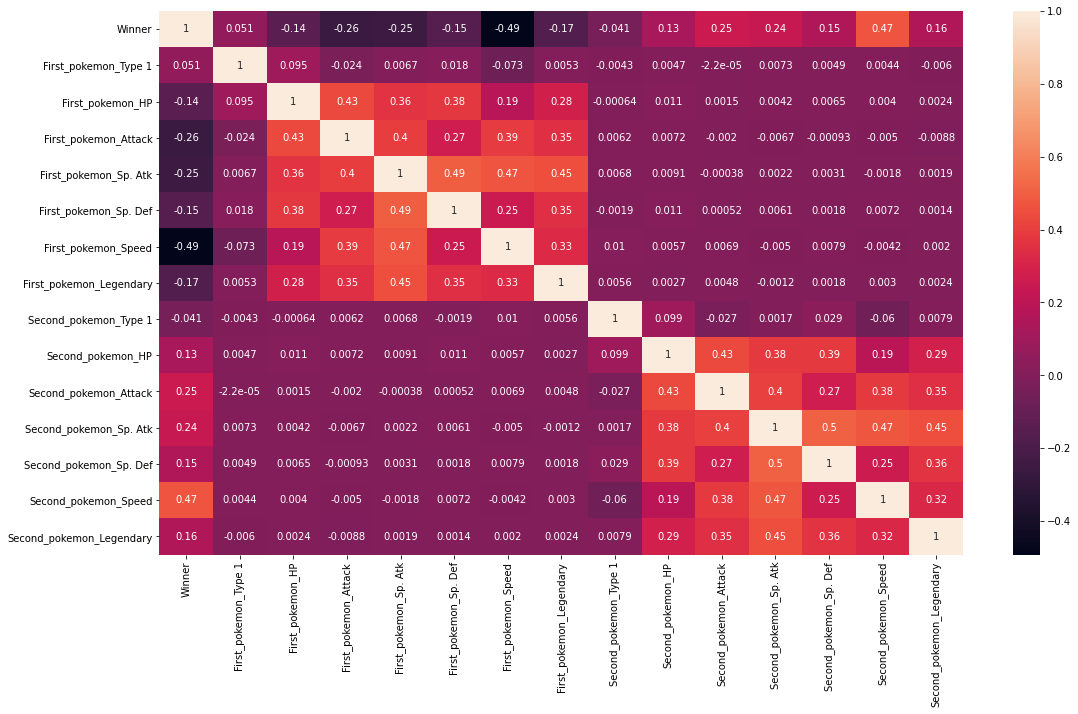

In [1038]:
corr = full_train_data.corr()
plt.figure(figsize=(18, 10))
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=True)

In [1039]:
X_train = full_train_data.drop(columns=['Winner'])
y_train = full_train_data.Winner

X_test = full_test_data.drop(columns='Winner')
y_test = full_test_data.Winner
X_train

,First_pokemon_Type 1,First_pokemon_HP,First_pokemon_Attack,First_pokemon_Sp. Atk,First_pokemon_Sp. Def,First_pokemon_Speed,First_pokemon_Legendary,Second_pokemon_Type 1,Second_pokemon_HP,Second_pokemon_Attack,Second_pokemon_Sp. Atk,Second_pokemon_Sp. Def,Second_pokemon_Speed,Second_pokemon_Legendary
0,10,115,140,55,55,40,0,12,75,100,60,66,115,0
1,10,89,145,105,80,91,1,4,95,65,110,130,60,0
2,14,106,110,154,90,130,1,8,43,70,50,60,38,0
3,2,80,90,130,110,110,1,9,60,62,62,60,40,0
4,9,75,75,75,95,113,0,14,106,110,154,90,130,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37495,10,65,75,35,65,85,0,12,84,71,71,43,48,0
37496,12,73,115,60,60,90,0,0,65,47,73,75,85,0
37497,2,45,50,55,75,40,0,3,35,55,45,40,60,0
37498,17,110,78,76,71,60,0,1,60,105,120,60,105,0


In [1007]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=20)

# Addestramento

In [1040]:
model = RandomForestClassifier(random_state=20)
model.fit(X_train, y_train)

print("Trained!")

Trained!


# Accuracy

In [1041]:
train_score = model.score(X_train, y_train)
print(f"Train set score: {round(train_score, 2) * 100}%")

Train set score: 100.0%


In [1042]:
test_score = model.score(X_test, y_test)
print(f"Test set score: {round(test_score, 2) * 100}%")

Test set score: 95.0%
